# Step II of Proposed Method :
* weakly supervised fine-tuning of the MLP trained at Step I 
* MIL training on the 279 cases (containing >250K tiles)
* add pretrained MLP on top of ResNet50 features of each tile obtaining **prediction per tile**
* aggregate tile predictions under the naive assumption **patient_prediction =  max(tiles_prediction)**
* trained using Adam optimizer with lr=0.001
* minimized weighted BCE loss with regard to class imbalance ratio 
* proposed a combined loss as a regularization strategy i.e imposing sparsity on the vector of local tile predictions:

**L = BCE(global_pred) + alpha * L1_norm(tiles_proba)/n_tiles**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-II-of-Proposed-Method-:" data-toc-modified-id="Step-II-of-Proposed-Method-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Step II of Proposed Method :</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Train-k-fold-CV-on-training-set" data-toc-modified-id="Train-k-fold-CV-on-training-set-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Train k-fold CV on training set</a></span></li><li><span><a href="#Plot-train-loss" data-toc-modified-id="Plot-train-loss-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Plot train loss</a></span></li><li><span><a href="#Retrain-ensemble-on-all-training-set" data-toc-modified-id="Retrain-ensemble-on-all-training-set-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Retrain ensemble on all training set</a></span></li></ul></li><li><span><a href="#Predict-test-set" data-toc-modified-id="Predict-test-set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict test set</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import tensorflow as tf
import keras

print("keras version: ", keras.__version__)
print("tf version: ", tf.__version__)

from keras.layers import *
from keras.models import *
from keras import optimizers 

from utils import *

keras version:  2.3.1
tf version:  2.1.0


Using TensorFlow backend.


# Parameters

In [2]:
n_ensembles = 1
n_splits = 5
batch_size = 10
lr = 1e-3
epochs = 30

use_pre_trained_mlp = True
fc_layer_size = [100,10]
dropout_rate = 0.6

alpha = 0         # Loss is BCE only

# Read Data

In [3]:
data_dir = Path('../chowder_data')

train_dir = data_dir / "train_input" / "resnet_features"
test_dir = data_dir / "test_input"  / "resnet_features"

train_output_filename = data_dir / "train_output.csv"

df = pd.read_csv(train_output_filename)

# Get the filenames for train
#filenames_train = [train_dir / "{}.npy".format(idx) for idx in train_output["ID"]]
filenames_train = sorted(train_dir.glob("*.npy"))
for filename in filenames_train:
    assert filename.is_file(), filename

# Get the labels
labels_train = df["Target"].values

assert len(filenames_train) == len(labels_train)

In [4]:
df['Path'] = filenames_train

In [5]:
df['tiles_count'] = get_number_tiles(filenames_train)

In [6]:
print(len(df), "Patients")
print(df.Target.value_counts())
df.head(10)

279 Patients
0    167
1    112
Name: Target, dtype: int64


,ID,Target,Path,tiles_count
0,1,0,../chowder_data/train_input/resnet_features/ID...,1000
1,2,0,../chowder_data/train_input/resnet_features/ID...,1000
2,3,0,../chowder_data/train_input/resnet_features/ID...,1000
3,5,0,../chowder_data/train_input/resnet_features/ID...,839
4,6,0,../chowder_data/train_input/resnet_features/ID...,1000
5,7,0,../chowder_data/train_input/resnet_features/ID...,999
6,8,1,../chowder_data/train_input/resnet_features/ID...,1000
7,9,0,../chowder_data/train_input/resnet_features/ID...,1000
8,10,1,../chowder_data/train_input/resnet_features/ID...,442
9,11,0,../chowder_data/train_input/resnet_features/ID...,1000


# Model

In [7]:
def get_model():
    if use_pre_trained_mlp:
        # load pre trained MLP
        base_model = keras.models.load_model("base_model.h5")
    else:
        # build MLP
        tile = Input((2048,))
        x = tile
        for fc in fc_layer_size:
            x = Dense(fc, activation='sigmoid')(x)
            if dropout_rate > 0:
                x = Dropout(dropout_rate)(x)
        tile_prediction = Dense(1, activation='sigmoid')(x)
        base_model = Model(inputs=tile, outputs=tile_prediction)
    
    input = Input(shape=(None, 2048))
    local_predictions = TimeDistributed(base_model)(input)

    global_prediction = GlobalMaxPool1D()(local_predictions)
    model = Model(inputs=input, outputs=global_prediction)
    
    # custom loss function
    def my_loss(y_true, y_pred):
        local_predictions_l1 = tf.reduce_sum(local_predictions) / tf.cast(tf.size(local_predictions), tf.float32)
        bce = keras.losses.binary_crossentropy(y_true, y_pred)
        return (bce + alpha * local_predictions_l1)
    
    loss = 'binary_crossentropy' if alpha==0 else my_loss
    
    model.compile(optimizers.Adam(lr),
                  loss=loss,
                  metrics=[tf.keras.metrics.AUC()])
    return model

In [8]:
model = get_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2048)        0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           205921    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
Total params: 205,921
Trainable params: 205,921
Non-trainable params: 0
_________________________________________________________________


# Train

## Train k-fold CV on training set

In [9]:
%%time

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df.Target.values), y=df.Target.values)
print("class weights", class_weights)

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

history_folds = []
aucs = []

for fold, (i_train, i_val) in enumerate(kf.split(df, df.Target)):
    
    print("Fold {} / {}".format(fold+1, n_splits))
    
    # get data

    df_train = df.iloc[i_train]
    df_val = df.iloc[i_val]
    
    train_generator = batch_generator(df_train, batch_size)
    val_generator = batch_generator(df_val, 1)
    
    train_steps = int(np.ceil(len(df_train)/batch_size))
    val_steps = len(df_val)
    
    # build model
    model = get_model()
    
    # train model
    history = model.fit(
                            train_generator,
                            steps_per_epoch=train_steps,
                            validation_data=val_generator,
                            validation_steps=val_steps,
                            epochs=epochs,
                            verbose=0,
                            class_weight=dict(enumerate(class_weights))
                        )
    
    auc = model.evaluate(val_generator, steps=val_steps, verbose=0)[1]
    print("Val AUC = {:.3f}".format(auc))
    aucs.append(auc)
    history_folds.append(history.history)
    
aucs = np.array(aucs)
print("***** Val AUC : {:.3f} +/- {:.3f} ***** ".format(aucs.mean(), aucs.std()))

class weights [0.83532934 1.24553571]
Fold 1 / 5
Val AUC = 0.953
Fold 2 / 5
Val AUC = 0.957
Fold 3 / 5
Val AUC = 0.948
Fold 4 / 5
Val AUC = 0.936
Fold 5 / 5
Val AUC = 0.943
***** Val AUC : 0.947 +/- 0.008 ***** 
CPU times: user 4min 53s, sys: 4min 16s, total: 9min 10s
Wall time: 9min 13s


## Plot train loss

<IPython.core.display.Javascript object>


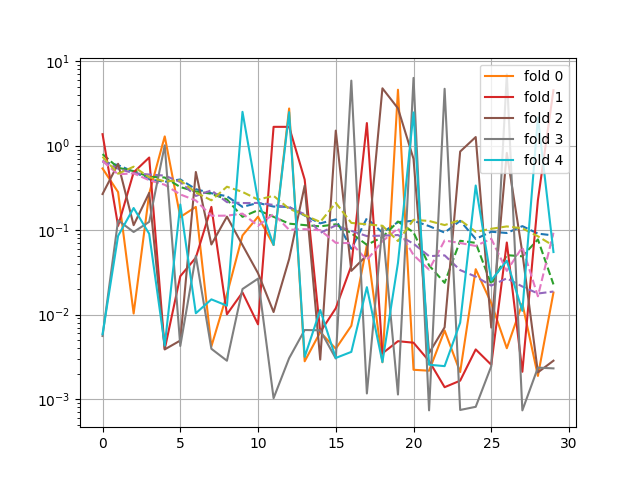

In [17]:
plt.figure()
for fold in range(len(history_folds)):
    plt.plot(history_folds[fold]['loss'], '--')
    plt.plot(history_folds[fold]['val_loss'], label='fold {}'.format(fold))
plt.yscale('log')
plt.legend()
plt.grid('on')

## Retrain ensemble on all training set

In [11]:
%%time
ensemble_models = []

for e in range(n_ensembles):
    print("Ensemble {} / {}".format(e+1, n_ensembles))
    generator = batch_generator(df, batch_size)
    steps = int(np.ceil(len(df)/batch_size))
    model = get_model()
    model.fit(generator,
              steps_per_epoch=steps,
              epochs=epochs,
              verbose=0,
              class_weight=dict(enumerate(class_weights)))
    ensemble_models.append(model)

Ensemble 1 / 1
CPU times: user 55.5 s, sys: 57.7 s, total: 1min 53s
Wall time: 1min 53s


# Predict test set

In [12]:
# get filenames of test set samples
filenames_test = sorted(test_dir.glob("*.npy"))
for filename in filenames_test:
    assert filename.is_file(), filename
    
# get features 
features_test = [np.load(f)[:,3:] for f in filenames_test]

In [13]:
# get predictions of all trained models in the ensemble
ensemble_prediction = [[model.predict(feature[None,...])[0] for feature in features_test] for model in ensemble_models]
ensemble_prediction = np.stack(ensemble_prediction, axis=0)

<IPython.core.display.Javascript object>


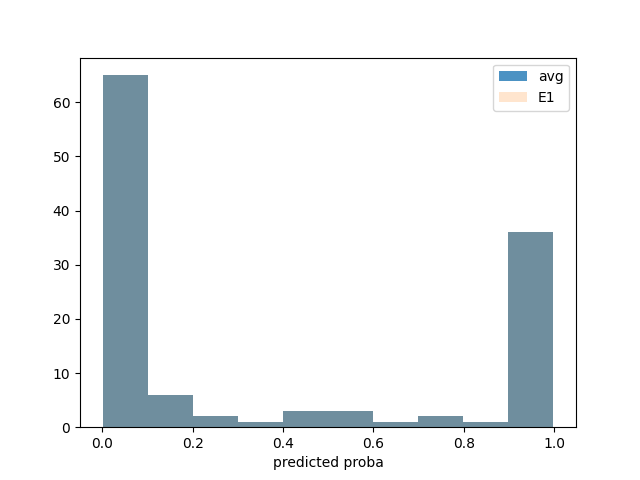

Text(0.5, 0, 'predicted proba')

In [16]:
plt.figure()
_=plt.hist(ensemble_prediction.mean(axis=0), alpha=0.8, label='avg')
for e in range(ensemble_prediction.shape[0]):
    _=plt.hist(ensemble_prediction[e], alpha=0.2, label="E{}".format(e+1))
plt.legend()
plt.xlabel('predicted proba')

In [15]:
# extract image IDs from filenames
ids = [re.search("ID_(.+?).npy", str(filename)).group(1) for filename in filenames_test]

# populate DF with IDs and predictions as average vote of ensembles
df_test = pd.DataFrame({'ID':ids, 'Target': ensemble_prediction.mean(axis=0).flatten()})
df_test.set_index("ID", inplace=True)
df_test.to_csv(data_dir / "preds_test_maxpool_pretrained={}_alpha={}_E={}.csv".format(use_pre_trained_mlp, alpha, n_ensembles))